In [1]:
import glob
import jsonlines
from pathlib import Path
import natsort
import json
from tqdm import tqdm
import pandas as pd

In [2]:
# Setup local directories
dataset_root = Path("/media/data/warp_data/marine_detection/imerit/whoi-rsi-fish-detection-datasets-22122023")
images_dir = "/media/data/warp_data/marine_detection/imerit/whoi-rsi-fish-detection-datasets-22122023"
manifest_path = "/media/data/warp_data/marine_detection/imerit/whoi-rsi-fish-detection-datasets-22122023/28102023_manifest.json"
coco_json_path = dataset_root / "coco.json"

# Parse manifest to get proper filenames and directories
# We use the relative path and video name with aws_id as GLOBAL_KEYS for LABELBOX
ordered_video_dirs = []
ordered_global_keys = []
ordered_videos_with_aws_ids = []
labelbox_external_id_to_global_key = {}
video_name_to_global_key = {}
replace_root = "s3://whoi-rsi-fish-detection/datasets/imerit_26102023_clips/"
with jsonlines.open(manifest_path) as f:
    for video_num, video_json in enumerate(f):
        video_path = Path(video_json['source-ref'].replace(replace_root, ""))
        ordered_video_dirs.append(video_path.parent)
        aws_id = video_num
        
        labelbox_name = video_path.parent.stem + f"_aws{aws_id}.mp4"
        video_name = str(video_path.parent)
        labelbox_global_key = str(video_path.parent) + f"_aws{aws_id}.mp4"
        
        ordered_videos_with_aws_ids.append(labelbox_name)
        ordered_global_keys.append(labelbox_global_key)
        labelbox_external_id_to_global_key[labelbox_name] = labelbox_global_key
        video_name_to_global_key[video_name] = labelbox_global_key
        
# Parse COCO json
with open(coco_json_path, "r") as f:
    coco = json.load(f)

In [4]:
def infer_site_from_filename(filename):
    filename_lower = filename.lower()
    inferred_site = None
    
    # Attempt to infer location, this is potentially brittle!
    if "yaw" in filename_lower or "yz" in filename_lower or "ya" in filename_lower:
        inferred_site = "Yawzi"
    elif "tek" in filename_lower or "tk" in filename_lower:
        inferred_site = "Tektite"
    elif "joel" in filename_lower or "js" in filename_lower:
        inferred_site = "Joels Shoal"
    elif "co" in filename_lower:
        inferred_site = "Cocoloba"
    elif "boo" in filename_lower or "br" in filename_lower:
        inferred_site = "Booby Rock"
    else:
        print(filename, " has no inferred site")

    return inferred_site

def infer_year_from_filename(filename):
    # Parse the years, this is potentially brittle!
    filename_lower = filename.lower()

    expected_years = range(2016,2025)
    inferred_year = None
    for expected_year in expected_years:
        if str(expected_year) in filename_lower:
            inferred_year = expected_year
    if not inferred_year:
        print(filename, " has no inferred year")

    return inferred_year

# Setup references
filestats = {}
for vid_num, vid_seq in enumerate(coco['video_sequences']):
    id = vid_seq['id']
    filename = vid_seq['file_name']
    filestats[id] = {}
    filestats[id]['filename'] = filename
    filestats[id]['annot_count'] = 0
    filestats[id]['fish_count'] = 0
    filestats[id]['inferred_site'] = None
    filestats[id]['inferred_year'] = None

    filestats[id]['inferred_site'] = infer_site_from_filename(filename)
    filestats[id]['inferred_year'] = infer_year_from_filename(filename)

# Setup references
framestats = {}
for vid_num, vid_seq in enumerate(coco['video_sequences']):
    for frame_num, frame_id in enumerate(vid_seq['image_id_list']):
        #id = vid_seq['id']
        id = frame_id
        filename = vid_seq['file_name']
        framestats[id] = {}
        framestats[id]['filename'] = filename
        framestats[id]['frame_num'] = frame_num
        framestats[id]['frame_filename'] = coco['images'][frame_id]['file_name']
        framestats[id]['annot_count'] = 0
        framestats[id]['fish_ids'] = []
        framestats[id]['inferred_site'] = None
        framestats[id]['inferred_year'] = None
    
        framestats[id]['inferred_site'] = infer_site_from_filename(filename)
        framestats[id]['inferred_year'] = infer_year_from_filename(filename)
    
# Gather video-level statistics
total_objs = 0
total_annot = 0
for obj_num, obj in enumerate(coco['object_tracks']):
    filestats[int(obj['video_seq_id'])]['fish_count'] += 1
    total_objs += 1

    filestats[int(obj['video_seq_id'])]['annot_count'] += len(obj['bbox_id_list'])
    total_annot += len(obj['bbox_id_list'])

# Gather frame-level statistics
# Output CSV format: video_name, frame_num, num_annotations, list of annotation IDs
for obj_num, obj in enumerate(coco['object_tracks']):
    for frame_id in obj['image_id_list']:
        framestats[frame_id]['annot_count'] += 1
        framestats[frame_id]['fish_ids'].append(obj['id'])

    

In [6]:
# Export to CSV format

# Video-level stats
df = pd.DataFrame(columns=filestats[0].keys())

for vid_num, vid_id in enumerate(filestats):
    df_new_row = pd.DataFrame.from_records([filestats[vid_id]])
    df = pd.concat([df, df_new_row])
df.to_csv("imerit_video_stats.csv", index=False)

# Image-level stats
df_images = pd.DataFrame(columns=framestats[0].keys())

for frame_num, frame_id in enumerate(framestats):
    df_new_row = pd.DataFrame.from_records([framestats[frame_id]])
    df_images = pd.concat([df_images, df_new_row])
df_images.to_csv("imerit_image_stats.csv", index=False)

/tmp/ipykernel_25948/1910476967.py:32: RuntimeWarning: invalid value encountered in divide
  norm_fc = fish_counts / vid_counts


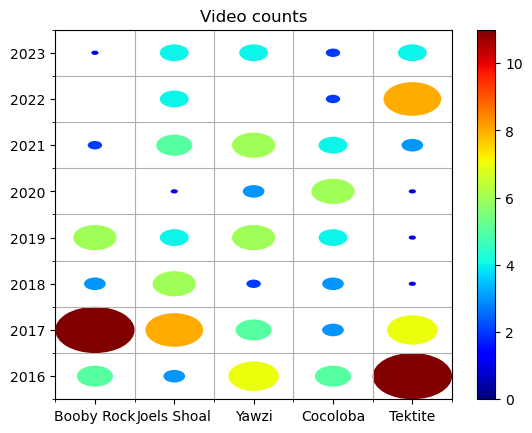

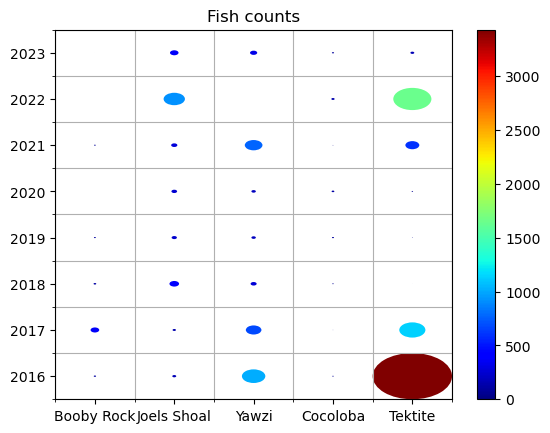

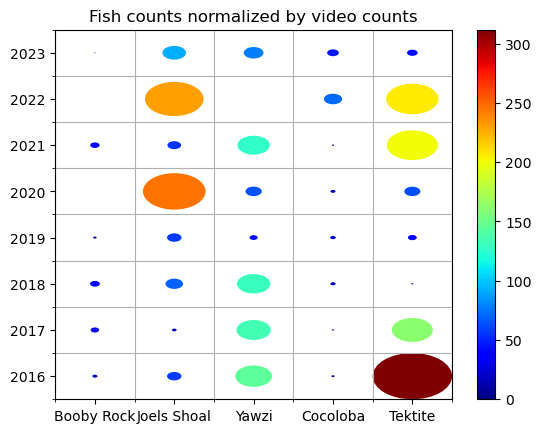

['Booby Rock' 'Joels Shoal' 'Yawzi' 'Cocoloba' 'Tektite']
[2016 2017 2018 2019 2020 2021 2022 2023]
[[ 20.          56.66666667 144.57142857  12.6        311.81818182]
 [ 34.          18.375      134.8          8.33333333 161.28571429]
 [ 38.66666667  69.33333333 131.          20.66666667   8.        ]
 [ 13.66666667  57.          32.          22.          35.        ]
 [  0.         246.          64.          20.          63.        ]
 [ 37.          53.8        127.33333333   8.75       200.66666667]
 [  0.         230.25         0.          71.5        206.        ]
 [  5.          92.5         77.75        46.          41.75      ]]
[[ 100.  170. 1012.   63. 3430.]
 [ 374.  147.  674.   25. 1129.]
 [ 116.  416.  262.   62.    8.]
 [  82.  228.  192.   88.   35.]
 [   0.  246.  192.  120.   63.]
 [  74.  269.  764.   35.  602.]
 [   0.  921.    0.  143. 1648.]
 [   5.  370.  311.   92.  167.]]


In [131]:
# Generate stat plots
from matplotlib import pyplot as plt
from matplotlib.collections import PatchCollection
import numpy as np

sites = pd.unique(df['inferred_site'])
years = pd.unique(df['inferred_year'])
years.sort()

num_sites = len(sites)
num_years = len(years)

# Gather stats based on site and year (spatiotemporal distribution)
fish_counts = np.zeros((num_sites, num_years))
vid_counts = np.zeros((num_sites, num_years))
annot_counts = np.zeros((num_sites, num_years))

for _,row in df.iterrows():
    # This video has over 1K+ juvenile fish, extreme outlier
    # if row["filename"] == "Nov2018_FishSurveys_WS/Tektite/P1010003_0m_18s":
    #     continue
    
    site = row["inferred_site"]
    year = row["inferred_year"]

    site_ind = np.where(site==sites)[0][0]
    year_ind = np.where(year==years)[0][0]
    
    fish_counts[site_ind][year_ind] += row["fish_count"]
    vid_counts[site_ind][year_ind] += 1
    annot_counts[site_ind][year_ind] += row["annot_count"]

norm_fc = fish_counts / vid_counts

fish_counts = fish_counts.T
vid_counts = vid_counts.T
annot_counts = annot_counts.T
norm_fc = norm_fc.T

# Plot patch representation of num_fish and num_vids vs site/year
x, y = np.meshgrid(range(num_sites), range(num_years))

rfc = fish_counts / fish_counts.max() / 2
rvc = vid_counts / vid_counts.max() / 2
ac = annot_counts / annot_counts.max() /2

norm_fc = np.nan_to_num(norm_fc)
rnfc = norm_fc / norm_fc.max() / 2

# Plot video counts
fig, ax = plt.subplots()
rvc_circ = [plt.Circle((j, i), radius=r) for j, i, r in zip(x.flat, y.flat, rvc.flat)] 
col = PatchCollection(rvc_circ, array=vid_counts.flatten(), cmap="jet")
ax.add_collection(col)
ax.set(xticks=range(num_sites), yticks=range(num_years), xticklabels=sites, yticklabels=years)
ax.set_xticks(np.arange(num_sites+1)-0.5, minor=True)
ax.set_yticks(np.arange(num_years+1)-0.5, minor=True)
ax.grid(which="minor")
ax.set_title("Video counts")
fig.colorbar(col)
plt.show()

# Plot fish counts
fig, ax = plt.subplots()
rfc_circ = [plt.Circle((j, i), radius=r) for j, i, r in zip(x.flat, y.flat, rfc.flat)] 
col = PatchCollection(rfc_circ, array=fish_counts.flat, cmap="jet")
ax.add_collection(col)
ax.set(xticks=range(num_sites), yticks=range(num_years), xticklabels=sites, yticklabels=years)
ax.set_xticks(np.arange(num_sites+1)-0.5, minor=True)
ax.set_yticks(np.arange(num_years+1)-0.5, minor=True)
ax.grid(which="minor")
ax.set_title("Fish counts")
fig.colorbar(col)
plt.show()

# Plot fish counts normalized by video counts
fig, ax = plt.subplots()
rnfc_circ = [plt.Circle((j, i), radius=r) for j, i, r in zip(x.flat, y.flat, rnfc.flat)] 
col = PatchCollection(rnfc_circ, array=norm_fc.flat, cmap="jet")
ax.add_collection(col)
ax.set(xticks=range(num_sites), yticks=range(num_years), xticklabels=sites, yticklabels=years)
ax.set_xticks(np.arange(num_sites+1)-0.5, minor=True)
ax.set_yticks(np.arange(num_years+1)-0.5, minor=True)
ax.grid(which="minor")
ax.set_title("Fish counts normalized by video counts")
fig.colorbar(col)
plt.show()

print(sites)
print(years)
print(norm_fc)
print(fish_counts)